---
title: Bayes-ball Part 3\: the credible interval
mathjax: true
toc: true
toc_sticky: true
toc_label:  'Contents'
categories: [data science, statistics]
---

In the [last post](https://benslack19.github.io/data%20science/statistics/prior-and-beta/), we learned about the beta distribution and why it would be a more realistic prior in the context of our problem. We also selected appropriate $\alpha$ and $\beta$ hyperparameters. Now we need to add in the data, work out the math, and see what kind of posterior distribution would result. We will then close with discussion on the [credible interval](https://en.wikipedia.org/wiki/Credible_interval) and how to interpret it in this problem. 

Let's get started!

In [3]:
# Load packages for coding examples
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import norm
sns.set_context('talk')   # visual theme

# Adding in the data and doing the math

Let's remind ourselves that the beta distribution prior established in the last post resulted in hyperparameters of $\alpha_{0}$ and $\beta_{0}$  as 17.5 and 82.5, respectively. This is the same code I showed previously.

a0, b0 values:  17.5 82.5


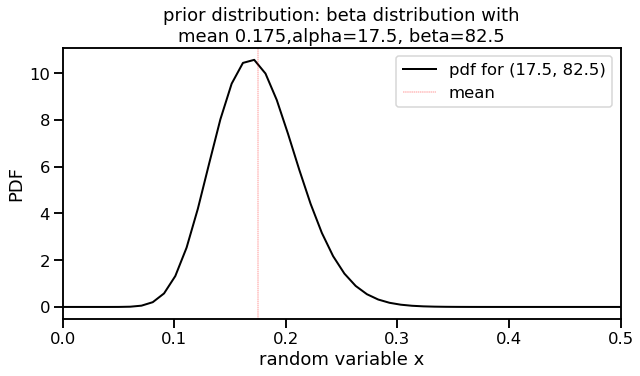

In [7]:
# Use a0 and b0 for our prior
mu = 0.175
total_ab = 100
a0 = mu*total_ab
b0 = total_ab-a0
print("a0, b0 values: ", a0, b0)

f, ax1 = plt.subplots(figsize=(10,5))
x = np.linspace(beta.ppf(0.00, a0, b0),
                beta.ppf(1.00, a0, b0), 100)
this_label = 'pdf for (' + str(a0) + ', ' + str(b0) + ')'

ax1.plot(x, beta.pdf(x, a0, b0), color='black',
         lw=2, label=this_label)
    
ax1.axvline(mu, lw=0.4, color='red', linestyle='dashed', label='mean')
ax1.set_title('prior distribution: beta distribution with\nmean 0.175,alpha=17.5, beta=82.5')
ax1.set_xlim([0, 0.5])
ax1.set_xlabel('random variable x')
ax1.set_ylabel('PDF')
ax1.legend();

Now let's add in the data from the original problem but make it more interesting. The original problem had Aguila getting 18 hits in 100 at-bats, which would essentially be the mean that we found above. I don't think we would learn as much this say. Therefore, let's say instead that he goes on a small streak and **gets 20 hits in only 50 at-bats**, for a .400 batting average in that streak. The [Robinson post](http://varianceexplained.org/statistics/beta_distribution_and_baseball/) highlights that it is super easy to get the posterior distribution. But I wanted to understand the math for why the posterior distribution can be obtained in the way he described. Let's look at some equations.

Let's start simple with the textbook definition of Bayes again.

$\text{P}(A|B) = \frac{\text{P}(B|A)\text{P}(A)}{\text{P}(B)}$

Now let's translate these terms into words and the context of our problem like we did in the previous post. One change we have to consider is that in [the original problem statement](https://benslack19.github.io/data%20science/statistics/b-bayes-ball/), we applied Bayes' Theorem towards a *point probability*. That is, we calculated a single, numerical value when we asked what probability would Aguila be in the T10 group. The prior was also a numerical value ("40% of all hitters were in the T10 group").

What we are really doing here is applying Bayes' Theorem towards a *probability distribution*. Therefore, we would Bayes in a similar form as what we have above, but amended it to reflect as:

$f(x|\text{data}) = \frac{f(\text{data}|x)f(x)}{f(\text{data})}$

Let's work through these terms as we did in the previous post.

<p><span style="color:darkblue">$f(x|\text{data})$</span>  The posterior probability distribution, resulting from updating the prior after seeing data. The left side of the equation is what we are trying to work out.</p>

The entire right side of the equation is information that we are given but is a little bit less intuitive to see.

<p><span style="color:darkblue">$f(\text{data}|x)$</span>  This is the likelihood or the sampling density for the data. We can work with the binomial probability mass function as we did originally: $\text{P}(X = k) = \binom n k p^k(1-p)^{n-k}$
<br>
However, later I'll explain why we can drop the binomial coefficient portion of this term and explain why a Bernoulli probability mass function would also work.</p>

<p><span style="color:darkblue">$f(x)$</span>  This is our prior distribution, the beta distribution with the hyperparameters we had stated above. (The form of the equation I'm showing here is a re-arrangement of the equation I showed in the previous post.)
    
$\frac{x^{\alpha_0-1}(1-x)^{\beta_0-1} \Gamma(\alpha_0+\beta_0)}{\Gamma(\alpha_0)\Gamma(\beta_0)}\$
</p>

<p><span style="color:darkblue">$f(\text{data})$</span> This acts as a normalizing constant. 
$f(\text{data}) = \int f(\text{data}|x)f(x)dx$ 

You can see that this is the integral of the likelihood times the prior. We do not have to worry too much about this normalizing term as we'll see. But one way that I understand this term is to recall what this term was in the [original Bayes-ball problem](https://benslack19.github.io/data%20science/statistics/b-bayes-ball/#putting-it-all-together) or even in the [Bertrand's box paradox problem](https://benslack19.github.io/data%20science/statistics/a-bertrands-box/#bayesian-approach). It is *all* instances of observing the data, independent of the condition. 
</p>

# Are we looking for a posterior predictive of the number of hits (counts) or are we doing probabilities (true talent rate)?

The term $f(\text{data}|x)$ is our likelihood function or the sampling density for the data. You can see that the data is shown "given x" or given a random variable. Hence what we know is that the data shows a binomial distribution where n = 100.

$"n choose k" x^k (1-x)^{n-k}$




$\text{P}(\text{T10} | \text{18H}) = \frac{\text{P}(\text{18H} | \text{T10})\text{P}(\text{T10})}{\text{P}(\text{18H})}$

In [133]:
beta.pdf(0.18, a0, b0)

10.132582493050725

In [139]:
beta.pdf((beta.pdf(0.18, a0, b0)*x), a0, b0) / 0.18

array([0.00000000e+00, 8.07745099e+00, 3.88467568e+01, 4.15751709e-01,
       1.05582750e-04, 7.70228957e-10, 7.35511413e-17, 1.15625645e-26,
       1.48240606e-41, 3.68229493e-70, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [128]:
x

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [44]:
a_post = a + 18 
b_post = b + (100-18)
print("posterior a, b values: ", a_post, b_post)

posterior a, b values:  193 907


Why does the y-axis go above 1? It's a density. You can u

In [45]:
beta.cdf([0.125, 0.150, 0.175, 0.200, 0.225], a, b)

array([2.97946338e-06, 1.58518348e-02, 5.07194956e-01, 9.78651290e-01,
       9.99954847e-01])

In [46]:
# Get credible interval
beta.ppf([0.025, 0.975], a_post, b_post)

array([0.15693997, 0.19464029])

In [32]:
#beta.pdf(x_post, a_post, b_post)

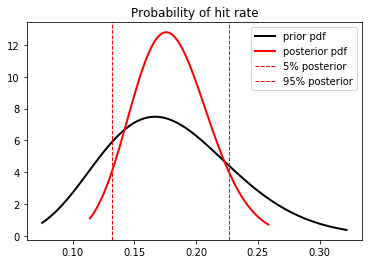

In [33]:
f, ax1 = plt.subplots()

ax1.plot(x, beta.pdf(x, a, b),
         'k-', lw=2, alpha=1, label='prior pdf')

x_post = np.linspace(beta.ppf(0.01, a_post, b_post),
                beta.ppf(0.99, a_post, b_post), 100)
ax1.plot(x_post, beta.pdf(x_post, a_post, b_post),
         'r-', lw=2, alpha=1, label='posterior pdf')
ax1.axvline(0.13198161, ymax=1, color='red', linestyle='dashed', lw=1, label='5% posterior')
ax1.axvline(0.22650857, ymax=1, color='red', linestyle='dashed', lw=1, label='95% posterior')

ax1.legend()
ax1.set_title('Probability of hit rate');

In [34]:
beta.pdf(x_post, a_post, b_post)

array([ 1.1003772 ,  1.25352291,  1.42155113,  1.60500699,  1.80434111,
        2.01989636,  2.25189531,  2.5004287 ,  2.76544517,  3.04674248,
        3.34396044,  3.65657579,  3.98389909,  4.32507386,  4.67907797,
        5.04472735,  5.42068205,  5.80545453,  6.1974202 ,  6.59483004,
        6.99582502,  7.3984524 ,  7.80068336,  8.20043195,  8.59557495,
        8.98397238,  9.36348843,  9.7320124 , 10.08747939, 10.42789046,
       10.75133204, 11.05599417, 11.34018745, 11.60235849, 11.84110365,
       12.05518085, 12.24351943, 12.40522799, 12.5396    , 12.64611733,
       12.72445168, 12.77446385, 12.79620107, 12.78989239, 12.75594232,
       12.69492279, 12.6075637 , 12.4947421 , 12.35747037, 12.19688336,
       12.01422487, 11.81083365, 11.58812895, 11.34759607, 11.09077176,
       10.81923003, 10.5345681 , 10.23839299,  9.9323087 ,  9.61790402,
        9.29674131,  8.97034604,  8.64019735,  8.30771964,  7.97427506,
        7.64115719,  7.30958562,  6.98070165,  6.65556492,  6.33

# The credible interval

# Testing end result

In [155]:
a, b = 18, 82

a_post = 18+20
b_post = 82+30

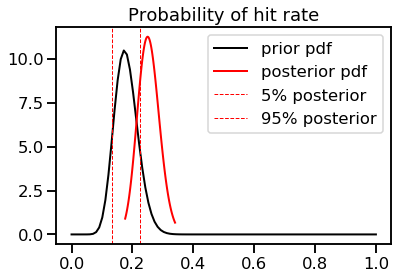

In [156]:
f, ax1 = plt.subplots()

ax1.plot(x, beta.pdf(x, a, b),
         'k-', lw=2, alpha=1, label='prior pdf')

x_post = np.linspace(beta.ppf(0.01, a_post, b_post),
                beta.ppf(0.99, a_post, b_post), 100)
ax1.plot(x_post, beta.pdf(x_post, a_post, b_post),
         'r-', lw=2, alpha=1, label='posterior pdf')
ax1.axvline(0.13198161, ymax=1, color='red', linestyle='dashed', lw=1, label='5% posterior')
ax1.axvline(0.22650857, ymax=1, color='red', linestyle='dashed', lw=1, label='95% posterior')

ax1.legend()
ax1.set_title('Probability of hit rate');

# References


By the way, David Robinson already wrote a [superb post](http://varianceexplained.org/r/credible_intervals_baseball/) on credible intervals, which also happened to use baseball statistics. I wanted to build on my previous example here, but I used his article for reference. I also found [this useful reference from Carnegie Mellon Statistics](http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf) and reviewed a Bayesian statistics course I completed from [Coursera add link](xxx).